# Dog Breed Identification

### Determine the breed of a dog in an image

You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo.


You can get the data here : https://www.kaggle.com/c/dog-breed-identification/data

## To do 

- [ ] **Play with Augmentations and Transforms.** 
- [ ] **Try to subset the data and work on that rather the whole dataset (Challenge).** 
- [ ] **Check out multi class log loss the evalation metrics for the problem.** 
- [ ] **Use Freeze and Unfreeze rather Fine tuning.** 
- [ ] **Play with batch size and try to find the maximum (where the error occured) and why it did.** 
- [ ] **If possible try with other models.** 
- [ ] **Refer WWf and try to re-implement.** 


* Customize the whole learner, with adding loss and optimizer function and try it out. 


In [ ]:
# Importing the packages 

from fastai.vision.all import *
import pandas as pd 
from fastai.vision import *


In [ ]:
# Reading in the label df 

df = pd.read_csv('labels.csv')
df

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [ ]:
# Train and test data

test_path = Path('test/')
train_path = Path('train/')

In [ ]:
fns_train = get_image_files(train_path)
fns_train

(#10222) [Path('train/f37af9dee180ed1195985decf4ef7111.jpg'),Path('train/547e9cca520970b35c1d9acb0a0fb902.jpg'),Path('train/4b66e3a702acaf31f438fbc12a529892.jpg'),Path('train/4256b386d18a2c34d9d2b982f3a692bd.jpg'),Path('train/0159b6457aac89f43d1c1931cdf7500b.jpg'),Path('train/9708b549ad1a33a5635220927e200fe5.jpg'),Path('train/9236bd07cce91361f798145b5edb8a78.jpg'),Path('train/549bd24432ca6245f78e5ce709b8a3f2.jpg'),Path('train/1929eb9a7cf1fe75c0731a27545d8893.jpg'),Path('train/77f5d224817632147c90ec5bf47a1a27.jpg')...]

In [ ]:
# Opening one image 

from PIL import Image 

im = Image.open(r'train/4b66e3a702acaf31f438fbc12a529892.jpg')  

im.shape

(500, 250)

In [ ]:
# Augmenting our data 

batch_tfms = aug_transforms(pad_mode = 'zeros' , min_scale = 0.5 , size=224 , batch = True)

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader(0, pref=f'train/' , suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1),
                   item_tfms = Resize(460), 
                    batch_tfms = batch_tfms)

In [ ]:
len(fns_train)

10222

In [ ]:
pets.dataloaders??

In [ ]:
dls = pets.dataloaders(df , batch_size = 64)

In [ ]:
dls.show_batch()

In [ ]:
# Checking how its batched 

list(dls)

In [ ]:
len(dls.vocab) , dls.vocab

## A Baseline for now

In [ ]:
# Training a model asap  -- BASELINE 

learn = cnn_learner(dls , resnet34 , metrics = [error_rate] , pretrained = True)

In [ ]:
# Finding the learning rate 

learn.fine_tune(3)

Hmm.. Not bad for a baseline one, but gotta tweak a bit and experiment whatever I learnt so far to see if I can make this any better. 

Fewer confusions happened, didnt expect this.

## Improving our model 



First we are going to train the model with some loss function and optimizers, not using the default given one. Then will observe the model's behaviour whether is there any improvement or not. 

Also try to increase the batch size a bit. 

* Gonna use a resnet18 instead of resnet34 and increase the number of epochs. The reason is to try with smaller arch and gradually increase as we go. 

In [ ]:
# Checking our model's parameters 

#learn.model.parameters() # we need this in our optimizer 

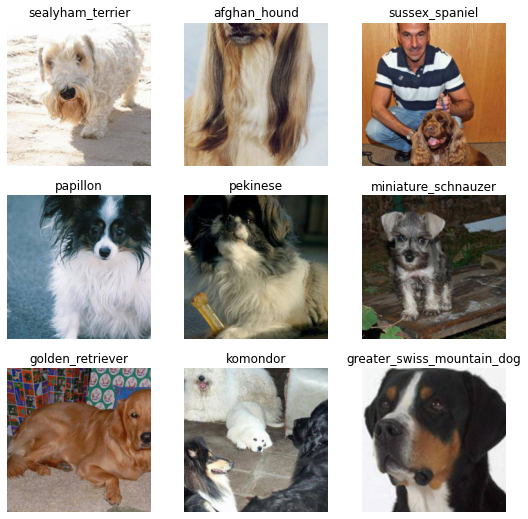

In [ ]:
# Changing the batch size 

dls = pets.dataloaders(df , bs = 64)
dls.show_batch()

In [ ]:
# Getting the loss function and optimizers 

loss_func = CrossEntropyLossFlat() 
accuracy = accuracy()

TypeError: accuracy() missing 2 required positional arguments: 'inp' and 'targ'

In [ ]:
# Baseline Model

learn_custom = cnn_learner(dls , loss_func=loss_func , arch = resnet18 , metrics = [error_rate , accuracy])
learn_custom.fine_tune(15 , freeze_epochs = 3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.784706,2.245671,0.547456,0.452544,01:00
1,2.266851,0.984376,0.295010,0.704990,01:00
2,1.502082,0.899163,0.266145,0.733855,01:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.094805,0.740585,0.221135,0.778865,01:17
1,0.990710,0.743290,0.221135,0.778865,01:16
2,0.913276,0.758762,0.220646,0.779354,01:16
3,0.858794,0.872328,0.257828,0.742172,01:15
4,0.800443,0.860139,0.251468,0.748532,01:15
5,0.719266,0.814986,0.238748,0.761252,01:50
6,0.612327,0.850121,0.240215,0.759785,01:45
7,0.549364,0.853450,0.238258,0.761742,01:16
8,0.455250,0.834192,0.229941,0.770059,01:16
9,0.368639,0.829264,0.230431,0.769569,01:16


In [ ]:

from fastai.callback.fp16 import * 
learn_custom = cnn_learner(dls , loss_func=loss_func , arch = resnet18 , metrics = [error_rate , accuracy]).to_fp16()

In [ ]:
# Finding the learning rate finder 

learn_custom.lr_find()

In [ ]:
1e-3 , 3e-3

In [ ]:
# Manually tweaking freezing and unfreezing 
lr = 1e-2
learn_custom = learn_custom.to_fp16()
learn_custom.fit_one_cycle(3)

In [ ]:
# Unfreezing the pretrained parameters / now its a full network 

learn_custom.unfreeze()

In [ ]:
# Learning rate finder after unfreezing all the pretrained params

learn_custom.lr_find()

In [ ]:
# Training the whole network 

learn_custom.fit_one_cycle(25 , lr_max = slice(1e-5 , 1e-4))

Alright since we are using `resnet18` the loss seems to stick with 0.834949 something. Well for now lets try to submit the results in Kaggle, got no idea how to parse those id's and prediction but lets see. After successfully submitting the results based on that we will move into `resnet34`


Atlast after searching for a long time, this thread was helpful : https://forums.fast.ai/t/how-to-get-predictions-for-all-images-in-a-folder/66364/3

In [ ]:
# Filenames for our test set 

fns_test = get_image_files(test_path)
fns_test

(#10357) [Path('test/7a10aa1b0b3e1215524c03e1928dabd0.jpg'),Path('test/c34aade3107de7d049c56c9d90f9d0b6.jpg'),Path('test/73fbb8ed8dbff26e9ccd31f60733f93e.jpg'),Path('test/d08c477d0d6b6060163c61f030699bb3.jpg'),Path('test/b20476845f34b078cf3f631b9e0e02f9.jpg'),Path('test/35f79c19258eb98fb71d9f2c4444ec24.jpg'),Path('test/3ab9651ad0afe847bf794be273196d1d.jpg'),Path('test/21e69bb2e4abde3db1207fb0414348ea.jpg'),Path('test/e381c5fcf1420985b20117e4bc7d38cd.jpg'),Path('test/0a7c46f223c4a4b7e7a2f25e8e023d73.jpg')...]

In [ ]:
# Getting test dataloader ready 

test_dl = dls.test_dl(fns_test)
test_dl

In [ ]:
# Getting the predictions for the test set 

test_pred = learn_custom.get_preds(dl = test_dl)

In [ ]:
test_pred[0]

TensorImage([[5.1270e-10, 2.3760e-07, 5.7304e-09,  ..., 1.1139e-07, 1.1410e-05,
         4.7280e-10],
        [4.2949e-10, 1.2460e-09, 2.5940e-11,  ..., 8.4597e-11, 1.0676e-12,
         1.6027e-13],
        [1.6644e-10, 2.1740e-08, 1.3477e-09,  ..., 7.1443e-07, 5.8021e-10,
         7.4388e-08],
        ...,
        [2.3624e-07, 2.1142e-04, 4.7133e-06,  ..., 7.4767e-08, 1.0345e-08,
         1.3624e-07],
        [7.6028e-12, 8.5927e-12, 1.3743e-11,  ..., 7.7839e-04, 6.2483e-09,
         1.5261e-10],
        [1.3963e-04, 3.4359e-05, 3.2909e-07,  ..., 1.4643e-06, 5.1722e-04,
         3.5481e-05]])

In [ ]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10353,fff1ec9e6e413275984966f745a313b0,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10354,fff74b59b758bbbf13a5793182a9bbe4,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10355,fff7d50d848e8014ac1e9172dc6762a3,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [ ]:
px = test_pred[0].numpy()
dum_df = pd.DataFrame(px)
dum_df

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,5.126967e-10,2.375985e-07,5.730446e-09,1.569382e-07,3.481329e-10,1.307322e-10,1.291704e-11,8.563089e-11,9.711901e-10,6.042061e-09,...,3.660764e-06,1.004534e-08,1.733329e-10,1.842921e-09,4.026580e-08,1.490256e-09,2.184033e-08,1.113920e-07,1.141012e-05,4.728042e-10
1,4.294881e-10,1.245979e-09,2.593988e-11,3.239737e-11,1.836072e-11,8.252940e-12,3.421393e-12,5.945537e-12,2.110085e-11,5.597460e-13,...,1.098013e-09,6.887869e-13,1.420732e-12,7.755370e-13,2.695779e-10,7.737625e-13,3.847117e-10,8.459719e-11,1.067557e-12,1.602708e-13
2,1.664377e-10,2.173996e-08,1.347651e-09,9.485698e-07,1.355294e-07,1.592530e-08,5.447521e-07,1.442441e-07,8.154913e-08,4.692585e-08,...,4.878499e-09,1.156861e-09,9.839703e-01,6.761898e-08,1.111749e-04,6.509127e-10,1.121442e-09,7.144288e-07,5.802094e-10,7.438756e-08
3,1.702075e-07,1.588055e-07,7.375041e-07,1.479495e-06,3.281576e-06,4.307653e-07,1.501089e-05,1.665757e-04,1.061893e-02,1.143726e-03,...,2.670696e-05,4.633171e-05,2.560036e-04,2.975176e-02,9.236647e-07,8.200343e-01,3.361992e-06,3.416069e-06,1.945333e-05,2.863673e-05
4,7.785025e-11,7.000074e-11,3.586964e-13,4.052795e-10,5.732054e-12,2.057784e-11,2.655112e-09,2.148648e-11,4.283077e-11,3.030473e-11,...,2.176876e-11,3.448899e-09,5.852220e-14,1.419609e-11,3.772157e-13,2.782339e-12,1.039460e-08,5.647123e-10,2.373667e-05,1.695153e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,4.606585e-07,2.252553e-05,1.074919e-04,3.687796e-03,3.565897e-05,8.026388e-04,7.055550e-05,1.349992e-06,3.023571e-05,1.240176e-03,...,5.242455e-05,4.318810e-04,3.025748e-04,1.184659e-04,1.260763e-03,2.537202e-05,2.601082e-06,7.004627e-06,2.101892e-05,3.940500e-05
10353,2.438396e-07,4.287960e-06,8.502599e-06,1.546025e-05,1.623666e-06,1.664809e-05,5.749721e-05,9.878423e-04,2.532163e-06,5.108499e-06,...,4.992353e-07,9.871858e-07,4.982203e-07,5.729160e-06,3.056074e-07,6.480671e-05,1.151935e-06,8.068969e-06,1.550859e-04,2.649206e-06
10354,2.362423e-07,2.114165e-04,4.713298e-06,5.828095e-06,1.166688e-07,1.988174e-06,2.561900e-07,1.344054e-07,3.761136e-06,6.880777e-06,...,1.988145e-06,1.275039e-08,2.457185e-07,1.005052e-06,2.283039e-07,1.961665e-06,2.082530e-07,7.476723e-08,1.034490e-08,1.362430e-07
10355,7.602779e-12,8.592676e-12,1.374345e-11,2.823811e-11,5.144484e-08,2.610144e-11,3.696286e-11,4.547542e-07,2.507798e-10,7.303593e-11,...,5.599454e-11,3.435501e-07,3.488996e-11,7.665364e-11,3.688272e-07,2.061196e-12,4.542150e-11,7.783892e-04,6.248281e-09,1.526148e-10


In [ ]:
pd.concat[[sample_submission['image_id'],dum],axis=1)

In [ ]:
new_df_pred = pd.DataFrame(test_pred[0])
new_df_pred

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,5.126967e-10,2.375985e-07,5.730446e-09,1.569382e-07,3.481329e-10,1.307322e-10,1.291704e-11,8.563089e-11,9.711901e-10,6.042061e-09,...,3.660764e-06,1.004534e-08,1.733329e-10,1.842921e-09,4.026580e-08,1.490256e-09,2.184033e-08,1.113920e-07,1.141012e-05,4.728042e-10
1,4.294881e-10,1.245979e-09,2.593988e-11,3.239737e-11,1.836072e-11,8.252940e-12,3.421393e-12,5.945537e-12,2.110085e-11,5.597460e-13,...,1.098013e-09,6.887869e-13,1.420732e-12,7.755370e-13,2.695779e-10,7.737625e-13,3.847117e-10,8.459719e-11,1.067557e-12,1.602708e-13
2,1.664377e-10,2.173996e-08,1.347651e-09,9.485698e-07,1.355294e-07,1.592530e-08,5.447521e-07,1.442441e-07,8.154913e-08,4.692585e-08,...,4.878499e-09,1.156861e-09,9.839703e-01,6.761898e-08,1.111749e-04,6.509127e-10,1.121442e-09,7.144288e-07,5.802094e-10,7.438756e-08
3,1.702075e-07,1.588055e-07,7.375041e-07,1.479495e-06,3.281576e-06,4.307653e-07,1.501089e-05,1.665757e-04,1.061893e-02,1.143726e-03,...,2.670696e-05,4.633171e-05,2.560036e-04,2.975176e-02,9.236647e-07,8.200343e-01,3.361992e-06,3.416069e-06,1.945333e-05,2.863673e-05
4,7.785025e-11,7.000074e-11,3.586964e-13,4.052795e-10,5.732054e-12,2.057784e-11,2.655112e-09,2.148648e-11,4.283077e-11,3.030473e-11,...,2.176876e-11,3.448899e-09,5.852220e-14,1.419609e-11,3.772157e-13,2.782339e-12,1.039460e-08,5.647123e-10,2.373667e-05,1.695153e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,4.606585e-07,2.252553e-05,1.074919e-04,3.687796e-03,3.565897e-05,8.026388e-04,7.055550e-05,1.349992e-06,3.023571e-05,1.240176e-03,...,5.242455e-05,4.318810e-04,3.025748e-04,1.184659e-04,1.260763e-03,2.537202e-05,2.601082e-06,7.004627e-06,2.101892e-05,3.940500e-05
10353,2.438396e-07,4.287960e-06,8.502599e-06,1.546025e-05,1.623666e-06,1.664809e-05,5.749721e-05,9.878423e-04,2.532163e-06,5.108499e-06,...,4.992353e-07,9.871858e-07,4.982203e-07,5.729160e-06,3.056074e-07,6.480671e-05,1.151935e-06,8.068969e-06,1.550859e-04,2.649206e-06
10354,2.362423e-07,2.114165e-04,4.713298e-06,5.828095e-06,1.166688e-07,1.988174e-06,2.561900e-07,1.344054e-07,3.761136e-06,6.880777e-06,...,1.988145e-06,1.275039e-08,2.457185e-07,1.005052e-06,2.283039e-07,1.961665e-06,2.082530e-07,7.476723e-08,1.034490e-08,1.362430e-07
10355,7.602779e-12,8.592676e-12,1.374345e-11,2.823811e-11,5.144484e-08,2.610144e-11,3.696286e-11,4.547542e-07,2.507798e-10,7.303593e-11,...,5.599454e-11,3.435501e-07,3.488996e-11,7.665364e-11,3.688272e-07,2.061196e-12,4.542150e-11,7.783892e-04,6.248281e-09,1.526148e-10


In [ ]:
whole_test = pd.concat([sample_sub['id'] , dum_df] , axis=1)
whole_test_col = whole_test.copy()

In [ ]:
whole_test_col.drop('id' , axis = 1 , inplace = True)
whole_test_col.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
      dtype='object', length=120)

In [ ]:
need_column = sample_sub.copy()
need_column.drop('id' , inplace=True , axis = 1)
need_column.columns # Gotchaaaa

Index(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller', 'australian_terrier',
       'basenji', 'basset', 'beagle',
       ...
       'toy_poodle', 'toy_terrier', 'vizsla', 'walker_hound', 'weimaraner',
       'welsh_springer_spaniel', 'west_highland_white_terrier', 'whippet',
       'wire-haired_fox_terrier', 'yorkshire_terrier'],
      dtype='object', length=120)

In [ ]:
# Taking the list of a column

column_list = []
for col in need_column.columns:
    column_list.append(col)

In [ ]:
# Renaming the columns 

whole_test_col.columns = column_list
whole_test_col

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,5.126967e-10,2.375985e-07,5.730446e-09,1.569382e-07,3.481329e-10,1.307322e-10,1.291704e-11,8.563089e-11,9.711901e-10,6.042061e-09,...,3.660764e-06,1.004534e-08,1.733329e-10,1.842921e-09,4.026580e-08,1.490256e-09,2.184033e-08,1.113920e-07,1.141012e-05,4.728042e-10
1,4.294881e-10,1.245979e-09,2.593988e-11,3.239737e-11,1.836072e-11,8.252940e-12,3.421393e-12,5.945537e-12,2.110085e-11,5.597460e-13,...,1.098013e-09,6.887869e-13,1.420732e-12,7.755370e-13,2.695779e-10,7.737625e-13,3.847117e-10,8.459719e-11,1.067557e-12,1.602708e-13
2,1.664377e-10,2.173996e-08,1.347651e-09,9.485698e-07,1.355294e-07,1.592530e-08,5.447521e-07,1.442441e-07,8.154913e-08,4.692585e-08,...,4.878499e-09,1.156861e-09,9.839703e-01,6.761898e-08,1.111749e-04,6.509127e-10,1.121442e-09,7.144288e-07,5.802094e-10,7.438756e-08
3,1.702075e-07,1.588055e-07,7.375041e-07,1.479495e-06,3.281576e-06,4.307653e-07,1.501089e-05,1.665757e-04,1.061893e-02,1.143726e-03,...,2.670696e-05,4.633171e-05,2.560036e-04,2.975176e-02,9.236647e-07,8.200343e-01,3.361992e-06,3.416069e-06,1.945333e-05,2.863673e-05
4,7.785025e-11,7.000074e-11,3.586964e-13,4.052795e-10,5.732054e-12,2.057784e-11,2.655112e-09,2.148648e-11,4.283077e-11,3.030473e-11,...,2.176876e-11,3.448899e-09,5.852220e-14,1.419609e-11,3.772157e-13,2.782339e-12,1.039460e-08,5.647123e-10,2.373667e-05,1.695153e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,4.606585e-07,2.252553e-05,1.074919e-04,3.687796e-03,3.565897e-05,8.026388e-04,7.055550e-05,1.349992e-06,3.023571e-05,1.240176e-03,...,5.242455e-05,4.318810e-04,3.025748e-04,1.184659e-04,1.260763e-03,2.537202e-05,2.601082e-06,7.004627e-06,2.101892e-05,3.940500e-05
10353,2.438396e-07,4.287960e-06,8.502599e-06,1.546025e-05,1.623666e-06,1.664809e-05,5.749721e-05,9.878423e-04,2.532163e-06,5.108499e-06,...,4.992353e-07,9.871858e-07,4.982203e-07,5.729160e-06,3.056074e-07,6.480671e-05,1.151935e-06,8.068969e-06,1.550859e-04,2.649206e-06
10354,2.362423e-07,2.114165e-04,4.713298e-06,5.828095e-06,1.166688e-07,1.988174e-06,2.561900e-07,1.344054e-07,3.761136e-06,6.880777e-06,...,1.988145e-06,1.275039e-08,2.457185e-07,1.005052e-06,2.283039e-07,1.961665e-06,2.082530e-07,7.476723e-08,1.034490e-08,1.362430e-07
10355,7.602779e-12,8.592676e-12,1.374345e-11,2.823811e-11,5.144484e-08,2.610144e-11,3.696286e-11,4.547542e-07,2.507798e-10,7.303593e-11,...,5.599454e-11,3.435501e-07,3.488996e-11,7.665364e-11,3.688272e-07,2.061196e-12,4.542150e-11,7.783892e-04,6.248281e-09,1.526148e-10


In [ ]:
submission = pd.concat([whole_test['id'] , whole_test_col] , axis = 1)
submission

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,5.126967e-10,2.375985e-07,5.730446e-09,1.569382e-07,3.481329e-10,1.307322e-10,1.291704e-11,8.563089e-11,9.711901e-10,...,3.660764e-06,1.004534e-08,1.733329e-10,1.842921e-09,4.026580e-08,1.490256e-09,2.184033e-08,1.113920e-07,1.141012e-05,4.728042e-10
1,00102ee9d8eb90812350685311fe5890,4.294881e-10,1.245979e-09,2.593988e-11,3.239737e-11,1.836072e-11,8.252940e-12,3.421393e-12,5.945537e-12,2.110085e-11,...,1.098013e-09,6.887869e-13,1.420732e-12,7.755370e-13,2.695779e-10,7.737625e-13,3.847117e-10,8.459719e-11,1.067557e-12,1.602708e-13
2,0012a730dfa437f5f3613fb75efcd4ce,1.664377e-10,2.173996e-08,1.347651e-09,9.485698e-07,1.355294e-07,1.592530e-08,5.447521e-07,1.442441e-07,8.154913e-08,...,4.878499e-09,1.156861e-09,9.839703e-01,6.761898e-08,1.111749e-04,6.509127e-10,1.121442e-09,7.144288e-07,5.802094e-10,7.438756e-08
3,001510bc8570bbeee98c8d80c8a95ec1,1.702075e-07,1.588055e-07,7.375041e-07,1.479495e-06,3.281576e-06,4.307653e-07,1.501089e-05,1.665757e-04,1.061893e-02,...,2.670696e-05,4.633171e-05,2.560036e-04,2.975176e-02,9.236647e-07,8.200343e-01,3.361992e-06,3.416069e-06,1.945333e-05,2.863673e-05
4,001a5f3114548acdefa3d4da05474c2e,7.785025e-11,7.000074e-11,3.586964e-13,4.052795e-10,5.732054e-12,2.057784e-11,2.655112e-09,2.148648e-11,4.283077e-11,...,2.176876e-11,3.448899e-09,5.852220e-14,1.419609e-11,3.772157e-13,2.782339e-12,1.039460e-08,5.647123e-10,2.373667e-05,1.695153e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,4.606585e-07,2.252553e-05,1.074919e-04,3.687796e-03,3.565897e-05,8.026388e-04,7.055550e-05,1.349992e-06,3.023571e-05,...,5.242455e-05,4.318810e-04,3.025748e-04,1.184659e-04,1.260763e-03,2.537202e-05,2.601082e-06,7.004627e-06,2.101892e-05,3.940500e-05
10353,fff1ec9e6e413275984966f745a313b0,2.438396e-07,4.287960e-06,8.502599e-06,1.546025e-05,1.623666e-06,1.664809e-05,5.749721e-05,9.878423e-04,2.532163e-06,...,4.992353e-07,9.871858e-07,4.982203e-07,5.729160e-06,3.056074e-07,6.480671e-05,1.151935e-06,8.068969e-06,1.550859e-04,2.649206e-06
10354,fff74b59b758bbbf13a5793182a9bbe4,2.362423e-07,2.114165e-04,4.713298e-06,5.828095e-06,1.166688e-07,1.988174e-06,2.561900e-07,1.344054e-07,3.761136e-06,...,1.988145e-06,1.275039e-08,2.457185e-07,1.005052e-06,2.283039e-07,1.961665e-06,2.082530e-07,7.476723e-08,1.034490e-08,1.362430e-07
10355,fff7d50d848e8014ac1e9172dc6762a3,7.602779e-12,8.592676e-12,1.374345e-11,2.823811e-11,5.144484e-08,2.610144e-11,3.696286e-11,4.547542e-07,2.507798e-10,...,5.599454e-11,3.435501e-07,3.488996e-11,7.665364e-11,3.688272e-07,2.061196e-12,4.542150e-11,7.783892e-04,6.248281e-09,1.526148e-10


In [ ]:
# Saving as a csv file 

submission.to_csv('submission.csv' , index = False)

In [ ]:
tes = pd.read_csv('submission.csv')
tes

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,5.126967e-10,2.375985e-07,5.730446e-09,1.569382e-07,3.481329e-10,1.307322e-10,1.291704e-11,8.563089e-11,9.711901e-10,...,3.660764e-06,1.004534e-08,1.733329e-10,1.842921e-09,4.026580e-08,1.490256e-09,2.184033e-08,1.113920e-07,1.141012e-05,4.728042e-10
1,00102ee9d8eb90812350685311fe5890,4.294881e-10,1.245979e-09,2.593988e-11,3.239737e-11,1.836072e-11,8.252940e-12,3.421393e-12,5.945537e-12,2.110085e-11,...,1.098013e-09,6.887869e-13,1.420732e-12,7.755370e-13,2.695779e-10,7.737625e-13,3.847117e-10,8.459719e-11,1.067557e-12,1.602708e-13
2,0012a730dfa437f5f3613fb75efcd4ce,1.664377e-10,2.173996e-08,1.347651e-09,9.485698e-07,1.355295e-07,1.592530e-08,5.447521e-07,1.442441e-07,8.154913e-08,...,4.878499e-09,1.156861e-09,9.839703e-01,6.761898e-08,1.111749e-04,6.509127e-10,1.121442e-09,7.144288e-07,5.802094e-10,7.438756e-08
3,001510bc8570bbeee98c8d80c8a95ec1,1.702075e-07,1.588055e-07,7.375041e-07,1.479495e-06,3.281576e-06,4.307653e-07,1.501089e-05,1.665757e-04,1.061892e-02,...,2.670696e-05,4.633171e-05,2.560036e-04,2.975176e-02,9.236647e-07,8.200343e-01,3.361992e-06,3.416069e-06,1.945333e-05,2.863673e-05
4,001a5f3114548acdefa3d4da05474c2e,7.785025e-11,7.000074e-11,3.586964e-13,4.052795e-10,5.732054e-12,2.057785e-11,2.655112e-09,2.148648e-11,4.283077e-11,...,2.176876e-11,3.448899e-09,5.852220e-14,1.419609e-11,3.772157e-13,2.782339e-12,1.039460e-08,5.647123e-10,2.373667e-05,1.695153e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,4.606585e-07,2.252553e-05,1.074919e-04,3.687796e-03,3.565897e-05,8.026388e-04,7.055550e-05,1.349992e-06,3.023572e-05,...,5.242455e-05,4.318810e-04,3.025748e-04,1.184659e-04,1.260763e-03,2.537202e-05,2.601082e-06,7.004627e-06,2.101892e-05,3.940500e-05
10353,fff1ec9e6e413275984966f745a313b0,2.438396e-07,4.287960e-06,8.502600e-06,1.546025e-05,1.623666e-06,1.664809e-05,5.749721e-05,9.878423e-04,2.532163e-06,...,4.992353e-07,9.871858e-07,4.982203e-07,5.729159e-06,3.056074e-07,6.480671e-05,1.151935e-06,8.068969e-06,1.550859e-04,2.649206e-06
10354,fff74b59b758bbbf13a5793182a9bbe4,2.362423e-07,2.114165e-04,4.713299e-06,5.828095e-06,1.166688e-07,1.988174e-06,2.561900e-07,1.344054e-07,3.761136e-06,...,1.988145e-06,1.275039e-08,2.457185e-07,1.005052e-06,2.283039e-07,1.961665e-06,2.082530e-07,7.476723e-08,1.034490e-08,1.362430e-07
10355,fff7d50d848e8014ac1e9172dc6762a3,7.602779e-12,8.592676e-12,1.374345e-11,2.823811e-11,5.144484e-08,2.610144e-11,3.696286e-11,4.547542e-07,2.507798e-10,...,5.599453e-11,3.435501e-07,3.488996e-11,7.665364e-11,3.688272e-07,2.061196e-12,4.542150e-11,7.783892e-04,6.248281e-09,1.526147e-10


Awesome!! But the score isn't nearly good enough. But we were able to submit it! That's all I want and now it's time to work on getting our model better! 